# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re

try:
    stopwords.words('dutch')
except LookupError:
    nltk.download('stopwords', quiet=True)

df = pd.read_csv('Uitgebreide_VKM_dataset.csv')
df.drop_duplicates(inplace=True); pd.set_option('display.max_columns', None)


In [ ]:
# Dataset overview
print("Dataset shape:", df.shape)
print("\nKolomnamen:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)

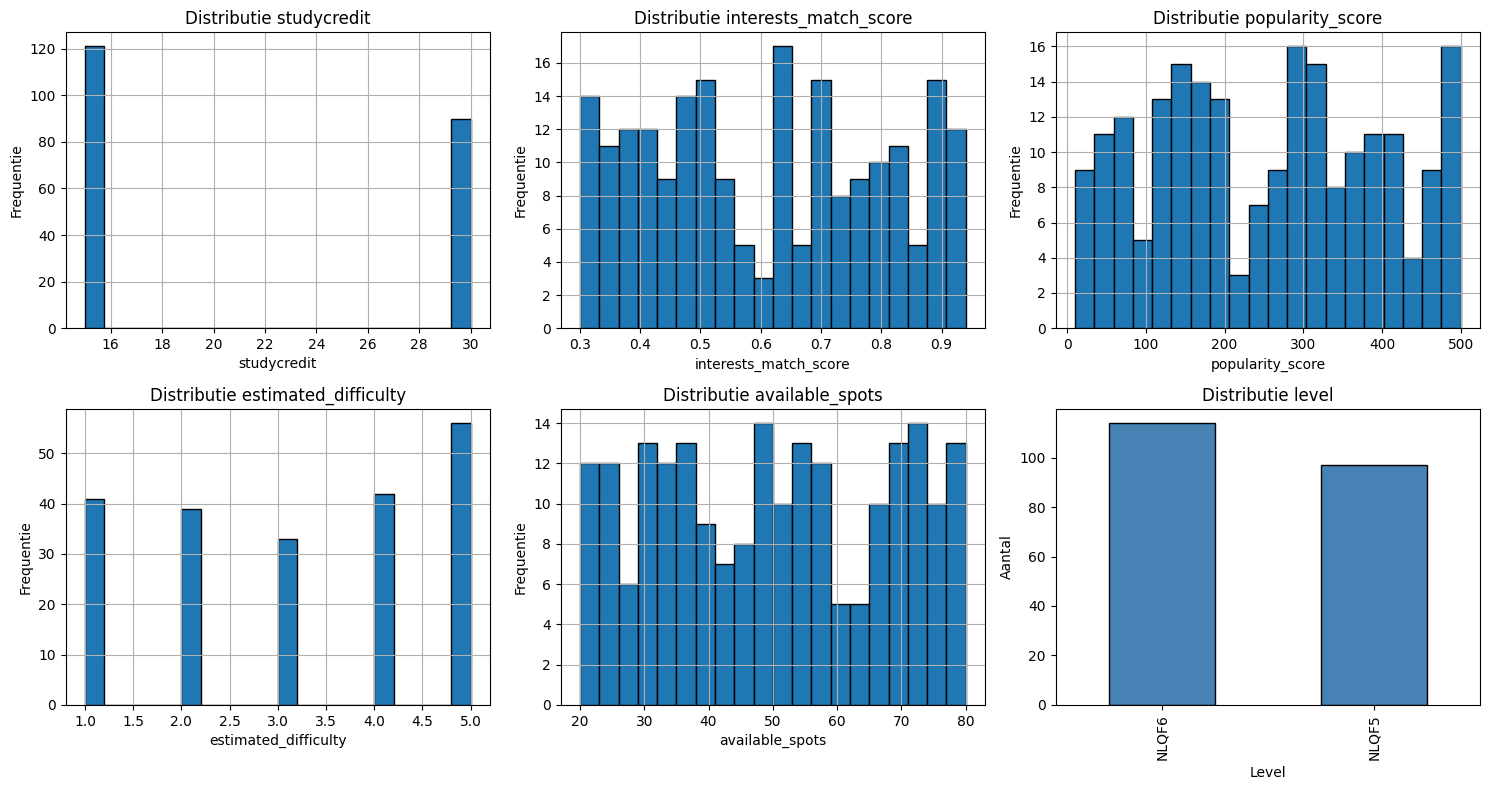

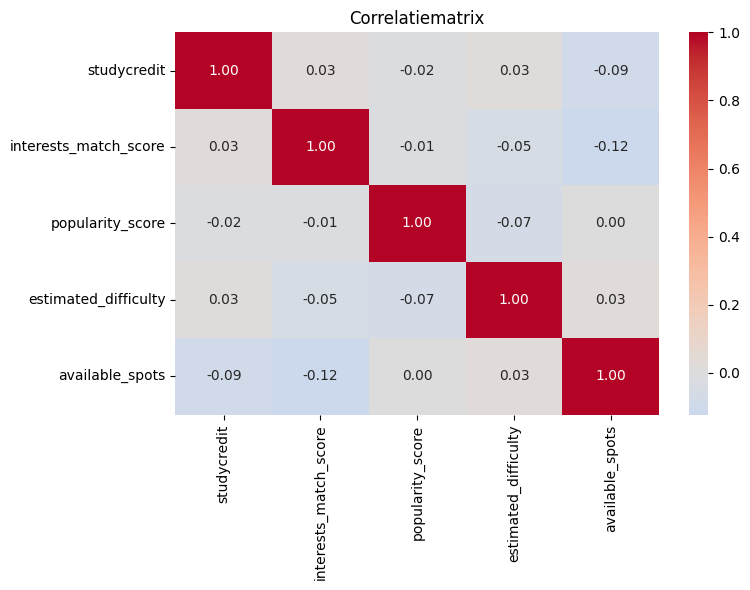

In [3]:
# Visualisaties
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Selecteer relevante numerieke kolommen (zonder Rood/Groen/Blauw/Geel en id's)
numeric_cols = ['studycredit', 'interests_match_score', 'popularity_score', 
                'estimated_difficulty', 'available_spots']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    df[col].hist(bins=20, ax=axes[idx], edgecolor='black')
    axes[idx].set_title(f'Distributie {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequentie')

# Categorical variables
df['level'].value_counts().plot(kind='bar', ax=axes[5], color='steelblue', edgecolor='black')
axes[5].set_title('Distributie level')
axes[5].set_xlabel('Level')
axes[5].set_ylabel('Aantal')

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlatiematrix')
plt.tight_layout()
plt.show()

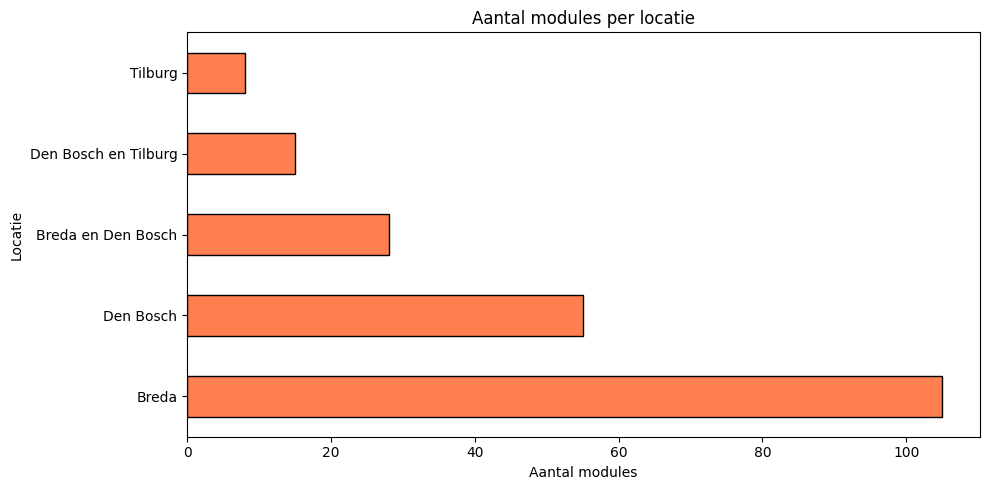

In [22]:
# Locatie analyse
location_counts = df['location'].value_counts()

plt.figure(figsize=(10, 5))
location_counts.plot(kind='barh', color='coral', edgecolor='black')
plt.title('Aantal modules per locatie')
plt.xlabel('Aantal modules')
plt.ylabel('Locatie')
plt.tight_layout()
plt.show()

Gemiddelde studycredits per level:
            mean  count
level                  
NLQF5  15.309278     97
NLQF6  26.578947    114


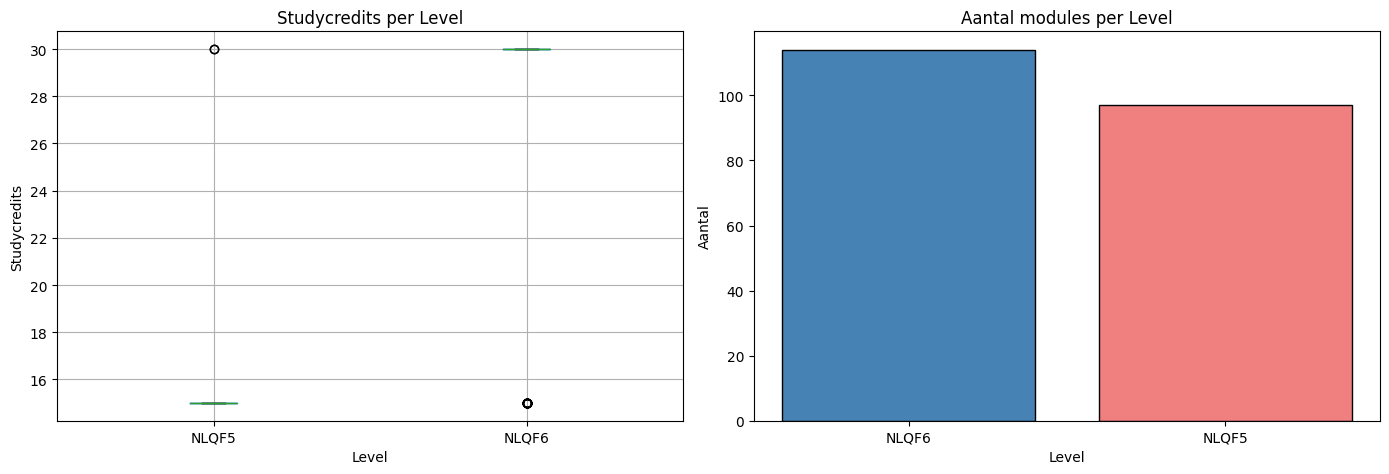

In [ ]:
# Studycredit vs Level analyse
credits_per_level = df.groupby('level')['studycredit'].agg(['mean', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
df.boxplot(column='studycredit', by='level', ax=axes[0])
axes[0].set_title('Studycredits per Level')
axes[0].set_xlabel('Level')
axes[0].set_ylabel('Studycredits')
plt.suptitle('')

# Count plot
level_counts = df['level'].value_counts()
axes[1].bar(level_counts.index, level_counts.values, color=['steelblue', 'lightcoral'], edgecolor='black')
axes[1].set_title('Aantal modules per Level')
axes[1].set_xlabel('Level')
axes[1].set_ylabel('Aantal')

plt.tight_layout()
plt.show()


Gemiddelde populariteit per moeilijkheidsgraad:
estimated_difficulty
1    287.2
2    255.5
3    215.0
4    254.3
5    252.4
Name: popularity_score, dtype: float64


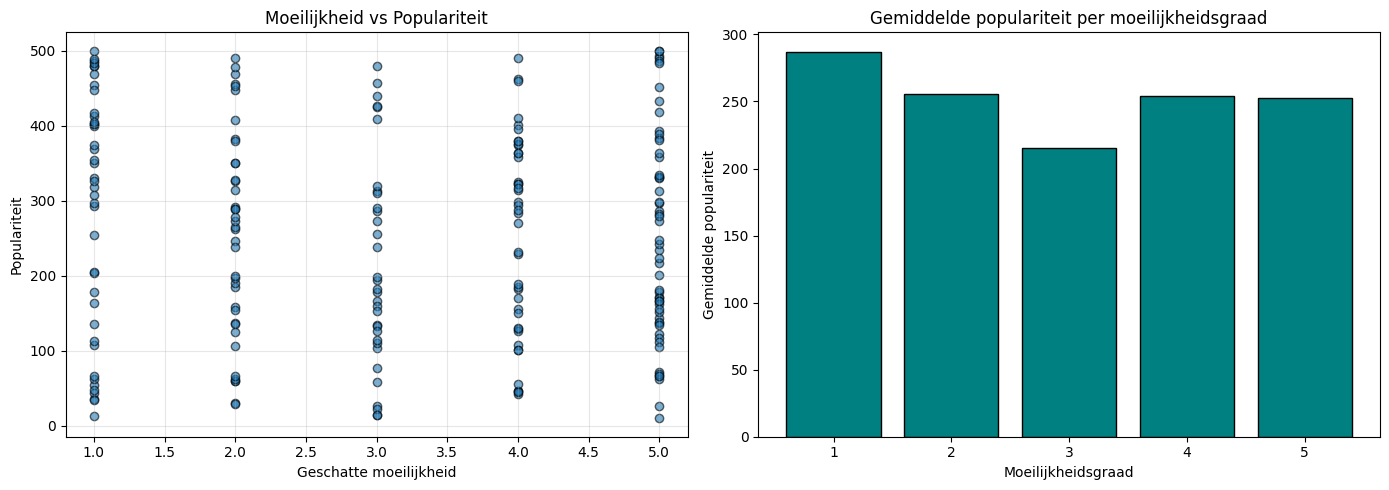

In [ ]:
# Moeilijkheid vs Populariteit
pop_per_difficulty = df.groupby('estimated_difficulty')['popularity_score'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(df['estimated_difficulty'], df['popularity_score'], alpha=0.6, edgecolor='black')
axes[0].set_xlabel('Geschatte moeilijkheid')
axes[0].set_ylabel('Populariteit')
axes[0].set_title('Moeilijkheid vs Populariteit')
axes[0].grid(alpha=0.3)

# Gemiddelde populariteit per moeilijkheidsgraad
axes[1].bar(pop_per_difficulty.index, pop_per_difficulty.values, color='teal', edgecolor='black')
axes[1].set_xlabel('Moeilijkheidsgraad')
axes[1].set_ylabel('Gemiddelde populariteit')
axes[1].set_title('Gemiddelde populariteit per moeilijkheidsgraad')

plt.tight_layout()
plt.show()

Interest match score statistieken:
  Gemiddelde: 0.61
  Mediaan: 0.62
  Min: 0.30
  Max: 0.94

Verdeling interest scores:
interests_match_score
Laag (0-0.4)           41
Gemiddeld (0.4-0.7)    93
Hoog (0.7-1.0)         77
Name: count, dtype: int64


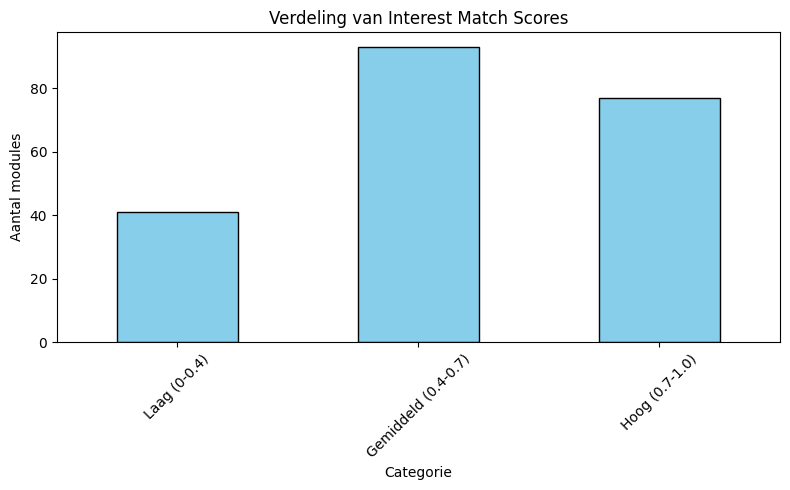

In [ ]:
# Interest match score analyse
interest_categories = pd.cut(df['interests_match_score'], 
                              bins=[0, 0.4, 0.7, 1.0], 
                              labels=['Laag (0-0.4)', 'Gemiddeld (0.4-0.7)', 'Hoog (0.7-1.0)'])

interest_dist = interest_categories.value_counts().sort_index()

plt.figure(figsize=(8, 5))
interest_dist.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Verdeling van Interest Match Scores')
plt.xlabel('Categorie')
plt.ylabel('Aantal modules')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Detecteer outliers in numerieke velden

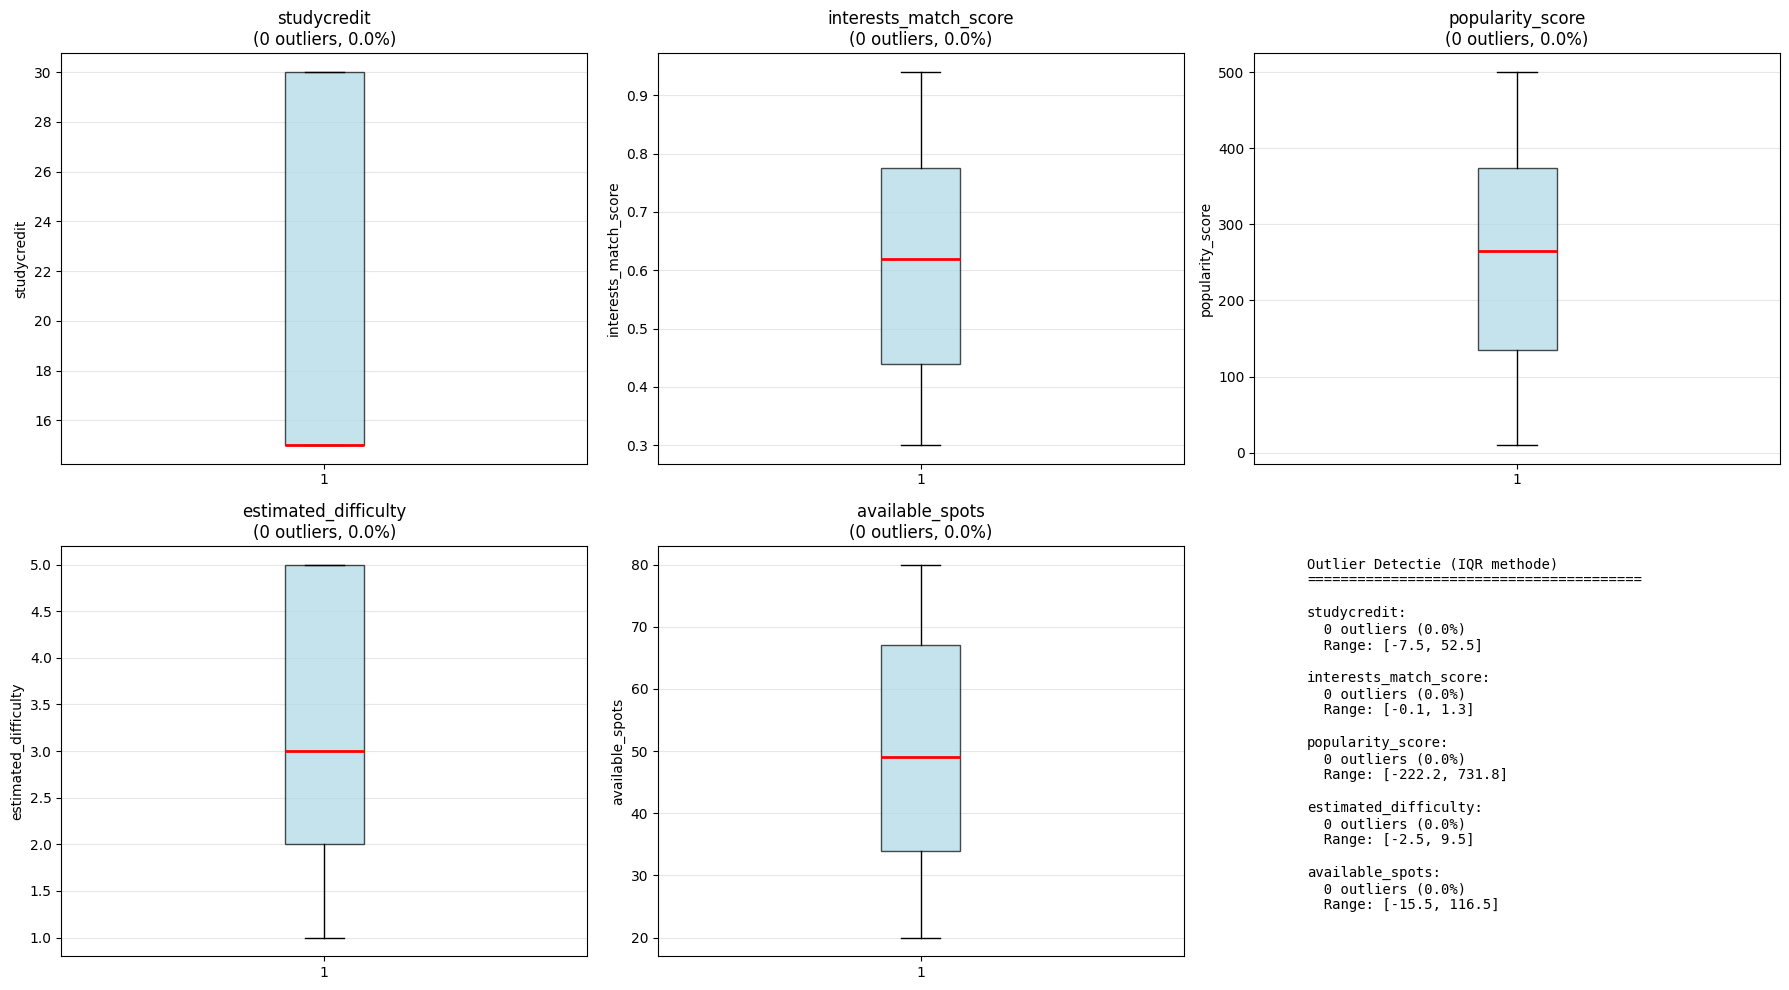

In [8]:
from scipy import stats

numeric_cols = ['studycredit', 'interests_match_score', 'popularity_score', 
                'estimated_difficulty', 'available_spots']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
outlier_summary = {}

for idx, col in enumerate(numeric_cols):
    data = df[col]
    
    # Bereken IQR grenzen
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(data < lower_bound) | (data > upper_bound)]
    outlier_summary[col] = {
        'count': len(outliers),
        'percentage': round(len(outliers) / len(df) * 100, 1),
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    axes[idx].boxplot(data, vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))
    axes[idx].set_ylabel(col)
    axes[idx].set_title(f'{col}\n({outlier_summary[col]["count"]} outliers, {outlier_summary[col]["percentage"]}%)')
    axes[idx].grid(axis='y', alpha=0.3)

axes[5].axis('off')
summary_text = "Outlier Detectie (IQR methode)\n" + "="*40 + "\n\n"
for col, info in outlier_summary.items():
    summary_text += f"{col}:\n  {info['count']} outliers ({info['percentage']}%)\n"
    summary_text += f"  Range: [{info['lower_bound']:.1f}, {info['upper_bound']:.1f}]\n\n"

axes[5].text(0.1, 0.5, summary_text, fontsize=10, family='monospace', verticalalignment='center')

plt.tight_layout()
plt.show()

## Correlatie analyse tussen numerieke variabelen

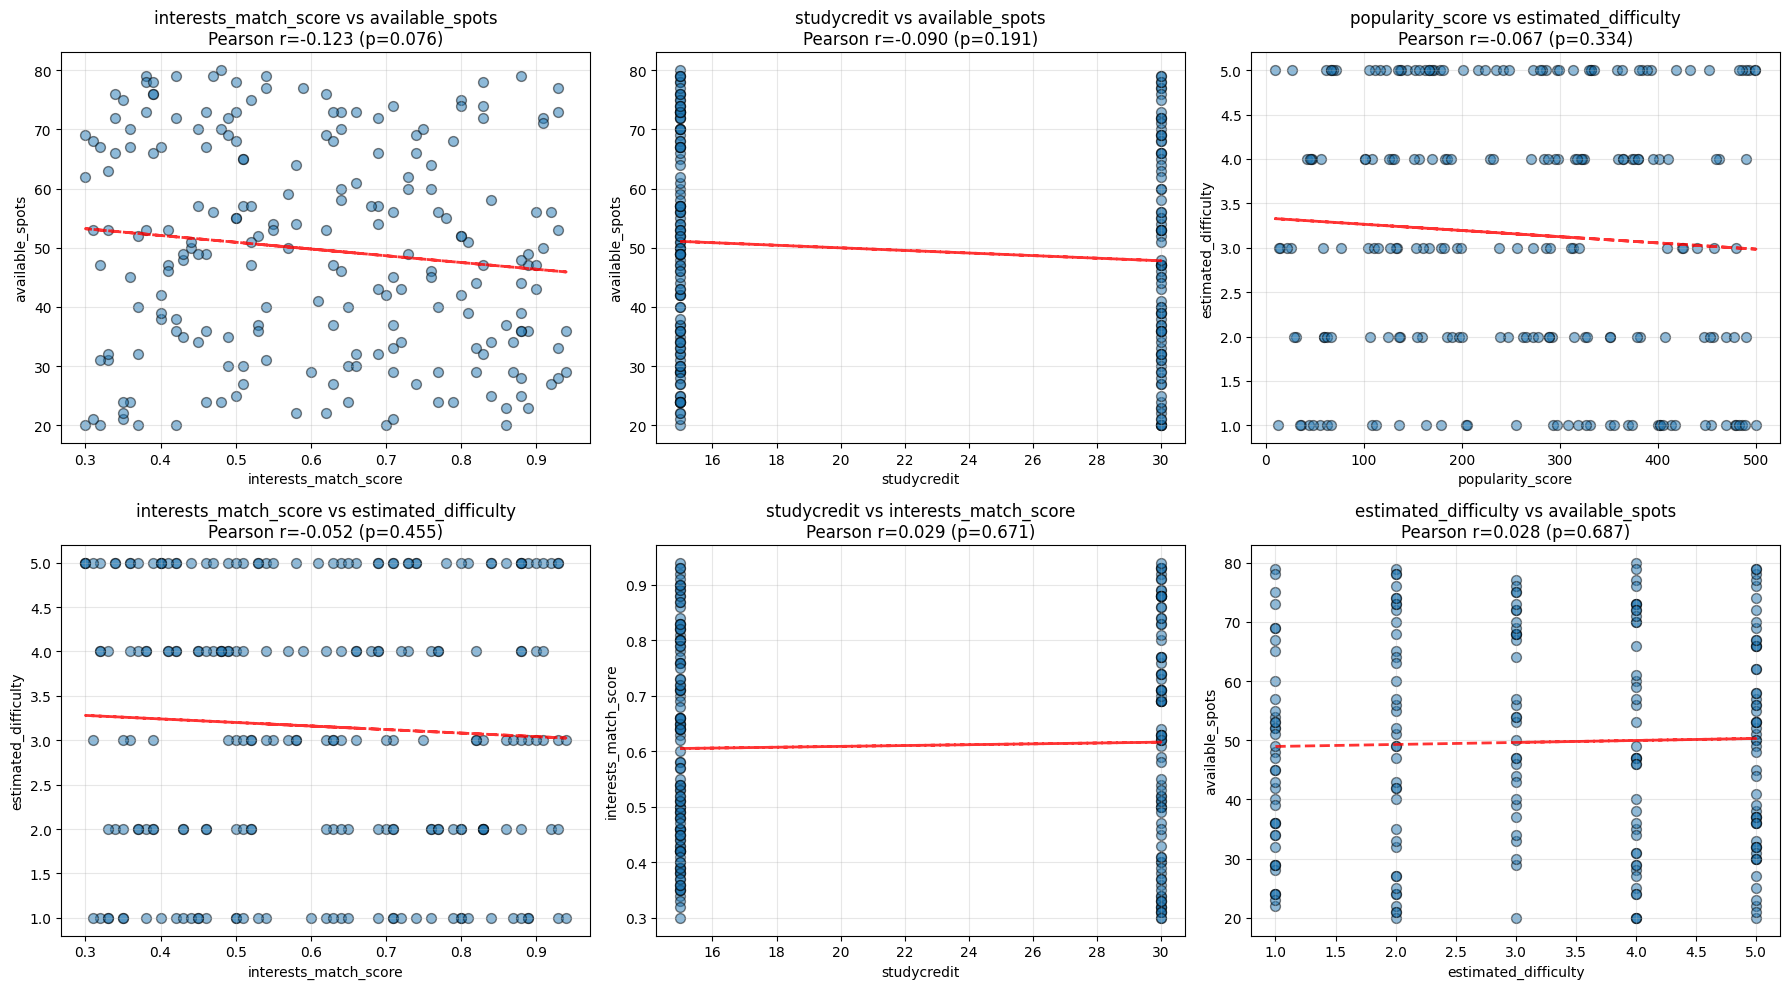

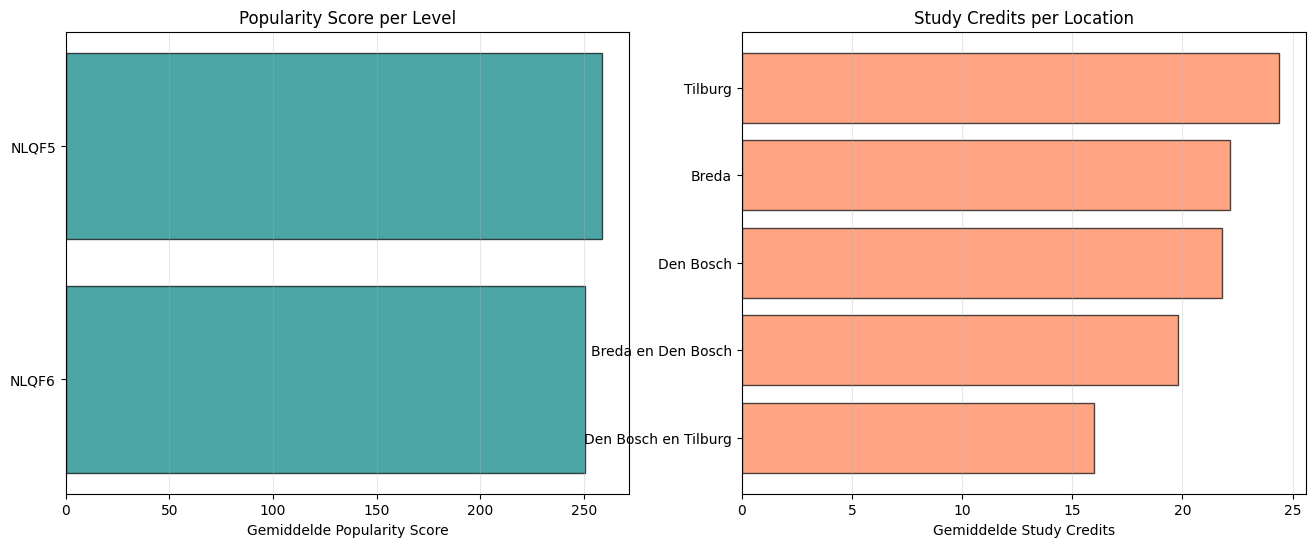

In [9]:
from scipy.stats import pearsonr, spearmanr

numeric_cols = ['studycredit', 'interests_match_score', 'popularity_score', 
                'estimated_difficulty', 'available_spots']

# Bereken correlaties voor alle combinaties
correlations = []
for i, col1 in enumerate(numeric_cols):
    for col2 in numeric_cols[i+1:]:
        pearson_r, pearson_p = pearsonr(df[col1], df[col2])
        spearman_r, spearman_p = spearmanr(df[col1], df[col2])
        
        correlations.append({
            'var1': col1,
            'var2': col2,
            'pearson_r': pearson_r,
            'pearson_p': pearson_p,
            'spearman_r': spearman_r,
            'spearman_p': spearman_p
        })

correlations_df = pd.DataFrame(correlations)
correlations_df['abs_pearson'] = correlations_df['pearson_r'].abs()
correlations_df = correlations_df.sort_values('abs_pearson', ascending=False)

top_6 = correlations_df.head(6)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(top_6.iterrows()):
    col1, col2 = row['var1'], row['var2']
    
    # Scatter plot met regressielijn
    axes[idx].scatter(df[col1], df[col2], alpha=0.5, edgecolor='black', s=50)
    
    # Trendlijn
    z = np.polyfit(df[col1], df[col2], 1)
    p = np.poly1d(z)
    axes[idx].plot(df[col1], p(df[col1]), "r--", linewidth=2, alpha=0.8)
    
    axes[idx].set_xlabel(col1)
    axes[idx].set_ylabel(col2)
    axes[idx].set_title(f'{col1} vs {col2}\nPearson r={row["pearson_r"]:.3f} (p={row["pearson_p"]:.3f})')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlaties met categorische variabelen
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Popularity vs Level
level_pop = df.groupby('level')['popularity_score'].mean().sort_values()
axes[0].barh(range(len(level_pop)), level_pop.values, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(level_pop)))
axes[0].set_yticklabels(level_pop.index)
axes[0].set_xlabel('Gemiddelde Popularity Score')
axes[0].set_title('Popularity Score per Level')
axes[0].grid(axis='x', alpha=0.3)

# Credits vs Location
loc_credits = df.groupby('location')['studycredit'].mean().sort_values()
axes[1].barh(range(len(loc_credits)), loc_credits.values, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(loc_credits)))
axes[1].set_yticklabels(loc_credits.index)
axes[1].set_xlabel('Gemiddelde Study Credits')
axes[1].set_title('Study Credits per Location')
axes[1].grid(axis='x', alpha=0.3)


## Test statistische relaties tussen variabelen

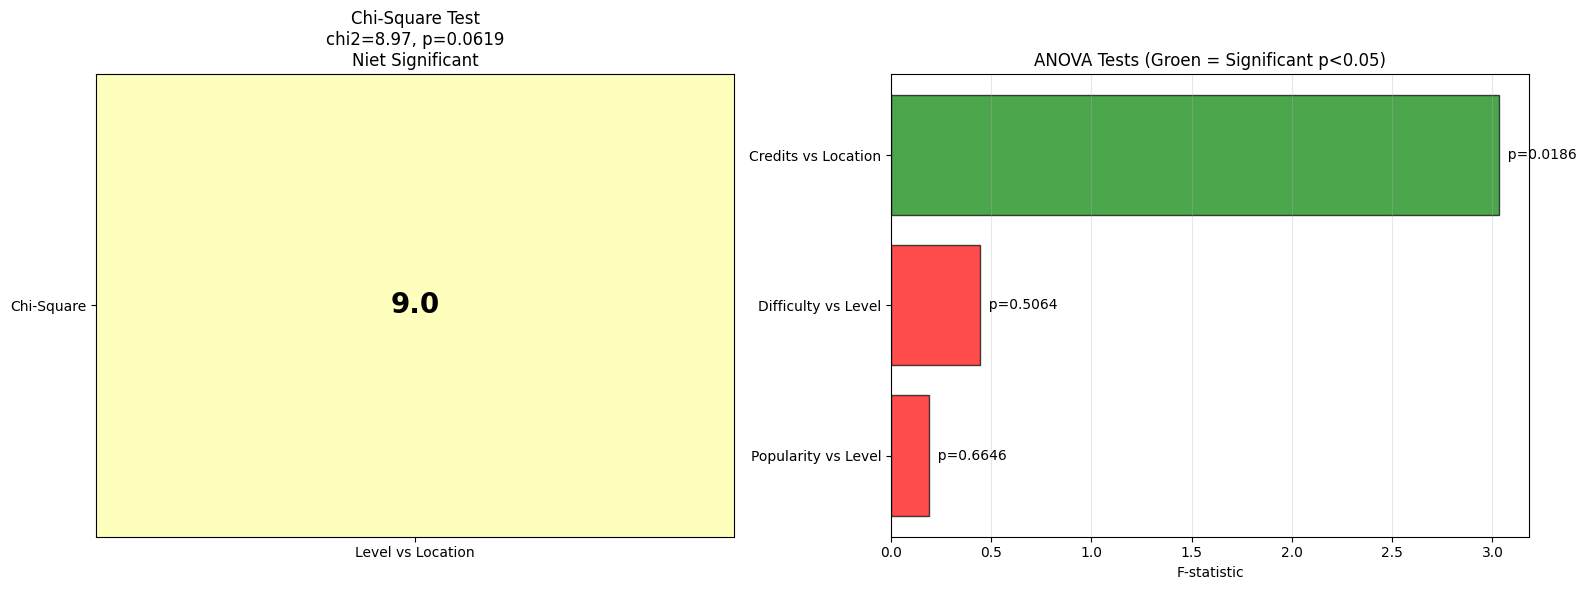

In [10]:
from scipy.stats import chi2_contingency, f_oneway

# Chi-Square test voor Level vs Location
contingency_table = pd.crosstab(df['level'], df['location'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 2. ANOVA tests: Numerieke variabelen per categorie
anova_results = []

# Test of popularity verschilt per level
level_groups = [df[df['level'] == lvl]['popularity_score'].values for lvl in df['level'].unique()]
f_stat, p_val = f_oneway(*level_groups)
anova_results.append({
    'test': 'Popularity vs Level',
    'f_statistic': f_stat,
    'p_value': p_val,
    'significant': 'Ja' if p_val < 0.05 else 'Nee'
})

# Test of difficulty verschilt per level
difficulty_groups = [df[df['level'] == lvl]['estimated_difficulty'].values for lvl in df['level'].unique()]
f_stat, p_val = f_oneway(*difficulty_groups)
anova_results.append({
    'test': 'Difficulty vs Level',
    'f_statistic': f_stat,
    'p_value': p_val,
    'significant': 'Ja' if p_val < 0.05 else 'Nee'
})

# Test of credits verschilt per location
location_groups = [df[df['location'] == loc]['studycredit'].values for loc in df['location'].unique()]
f_stat, p_val = f_oneway(*location_groups)
anova_results.append({
    'test': 'Credits vs Location',
    'f_statistic': f_stat,
    'p_value': p_val,
    'significant': 'Ja' if p_val < 0.05 else 'Nee'
})

# Visualisatie van test resultaten
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chi-square resultaat visualisatie
axes[0].imshow([[chi2]], cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=chi2*2)
axes[0].set_xticks([0])
axes[0].set_yticks([0])
axes[0].set_xticklabels(['Level vs Location'])
axes[0].set_yticklabels(['Chi-Square'])
axes[0].set_title(f'Chi-Square Test\nchi2={chi2:.2f}, p={p_value:.4f}\n{"Significant" if p_value < 0.05 else "Niet Significant"}')

for i in range(1):
    for j in range(1):
        text = axes[0].text(j, i, f'{chi2:.1f}',
                           ha="center", va="center", color="black", fontsize=20, weight='bold')

# ANOVA resultaten
anova_df = pd.DataFrame(anova_results)
colors = ['green' if sig == 'Ja' else 'red' for sig in anova_df['significant']]

axes[1].barh(anova_df['test'], anova_df['f_statistic'], color=colors, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('F-statistic')
axes[1].set_title('ANOVA Tests (Groen = Significant p<0.05)')
axes[1].grid(axis='x', alpha=0.3)

# Voeg p-values toe als tekst
for idx, (test, f_stat, p_val, sig) in anova_df.iterrows():
    axes[1].text(f_stat, idx, f'  p={p_val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Data Quality Analysis

## Detecteer lege en ontbrekende waarden per kolom

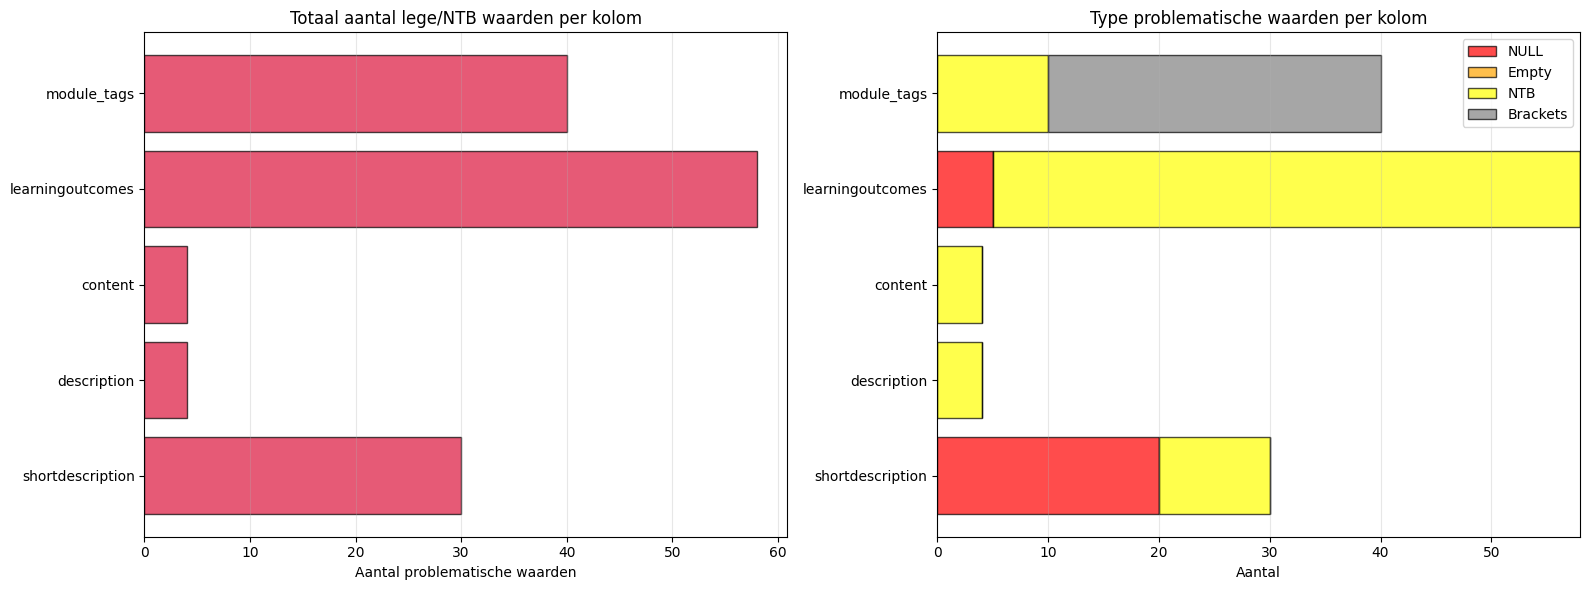


Conclusie: 5 kolommen hebben datakwaliteitsproblemen


In [ ]:
quality_issues = {}

for col in df.columns:
    if df[col].dtype == 'object':
        null_count = df[col].isnull().sum()
        empty_count = (df[col].astype(str).str.strip() == '').sum()
        ntb_variations = df[col].astype(str).str.lower().str.contains('ntb|nog te bepalen|nog niet bekend|nog te formuleren', na=False).sum()
        bracket_empty = df[col].astype(str).str.strip().isin(['[]', "['ntb']", '["ntb"]']).sum()
        
        total_issues = null_count + empty_count + ntb_variations + bracket_empty
        
        if total_issues > 0:
            quality_issues[col] = {
                'NULL': null_count,
                'Empty': empty_count,
                'NTB': ntb_variations,
                'Brackets': bracket_empty,
                'Total': total_issues,
                'Percentage': round((total_issues / len(df)) * 100, 1)
            }

# Visualisatie
if quality_issues:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart van totale problemen per kolom
    cols = list(quality_issues.keys())
    totals = [quality_issues[col]['Total'] for col in cols]
    percentages = [quality_issues[col]['Percentage'] for col in cols]
    
    axes[0].barh(cols, totals, color='crimson', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Aantal problematische waarden')
    axes[0].set_title('Totaal aantal lege/NTB waarden per kolom')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Stacked bar voor type problemen
    null_vals = [quality_issues[col]['NULL'] for col in cols]
    empty_vals = [quality_issues[col]['Empty'] for col in cols]
    ntb_vals = [quality_issues[col]['NTB'] for col in cols]
    bracket_vals = [quality_issues[col]['Brackets'] for col in cols]
    
    y_pos = np.arange(len(cols))
    axes[1].barh(y_pos, null_vals, label='NULL', color='red', edgecolor='black', alpha=0.7)
    axes[1].barh(y_pos, empty_vals, left=null_vals, label='Empty', color='orange', edgecolor='black', alpha=0.7)
    axes[1].barh(y_pos, ntb_vals, left=np.array(null_vals)+np.array(empty_vals), label='NTB', color='yellow', edgecolor='black', alpha=0.7)
    axes[1].barh(y_pos, bracket_vals, left=np.array(null_vals)+np.array(empty_vals)+np.array(ntb_vals), label='Brackets', color='gray', edgecolor='black', alpha=0.7)
    
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(cols)
    axes[1].set_xlabel('Aantal')
    axes[1].set_title('Type problematische waarden per kolom')
    axes[1].legend()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Analyseer tekstlengtes voor kwaliteitscontrole

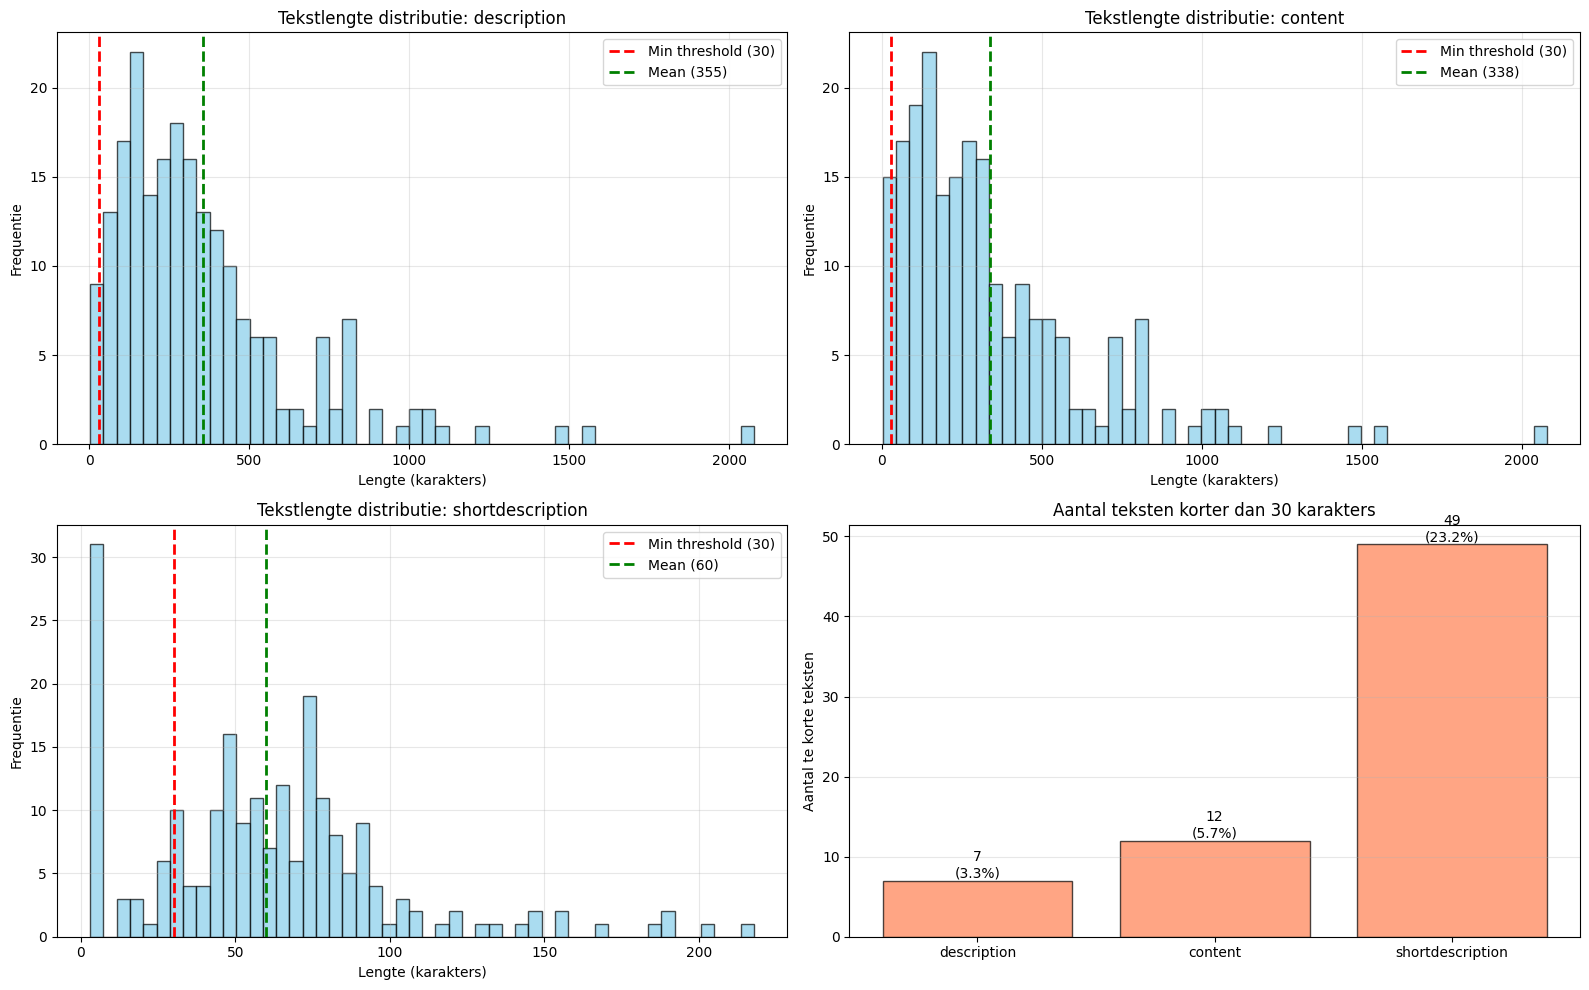


Conclusie: 68 totale tekstvelden zijn te kort voor goede analyse


In [ ]:
text_fields = ['description', 'content', 'shortdescription']
min_length_threshold = 30
length_analysis = {}

for field in text_fields:
    lengths = df[field].astype(str).str.len()
    too_short = (lengths < min_length_threshold).sum()
    
    length_analysis[field] = {
        'min': lengths.min(),
        'max': lengths.max(),
        'mean': lengths.mean(),
        'median': lengths.median(),
        'too_short': too_short,
        'too_short_pct': round((too_short / len(df)) * 100, 1)
    }
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram van lengtes per veld
for idx, field in enumerate(text_fields):
    row = idx // 2
    col = idx % 2
    
    lengths = df[field].astype(str).str.len()
    axes[row, col].hist(lengths, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
    axes[row, col].axvline(min_length_threshold, color='red', linestyle='--', linewidth=2, label=f'Min threshold ({min_length_threshold})')
    axes[row, col].axvline(length_analysis[field]['mean'], color='green', linestyle='--', linewidth=2, label=f"Mean ({length_analysis[field]['mean']:.0f})")
    axes[row, col].set_xlabel('Lengte (karakters)')
    axes[row, col].set_ylabel('Frequentie')
    axes[row, col].set_title(f'Tekstlengte distributie: {field}')
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)
fields = list(length_analysis.keys())
too_short_counts = [length_analysis[f]['too_short'] for f in fields]
axes[1, 1].bar(fields, too_short_counts, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Aantal te korte teksten')
axes[1, 1].set_title(f'Aantal teksten korter dan {min_length_threshold} karakters')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, count in enumerate(too_short_counts):
    pct = length_analysis[fields[i]]['too_short_pct']
    axes[1, 1].text(i, count, f'{count}\n({pct}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Analyseer meest voorkomende woorden in bestaande tags

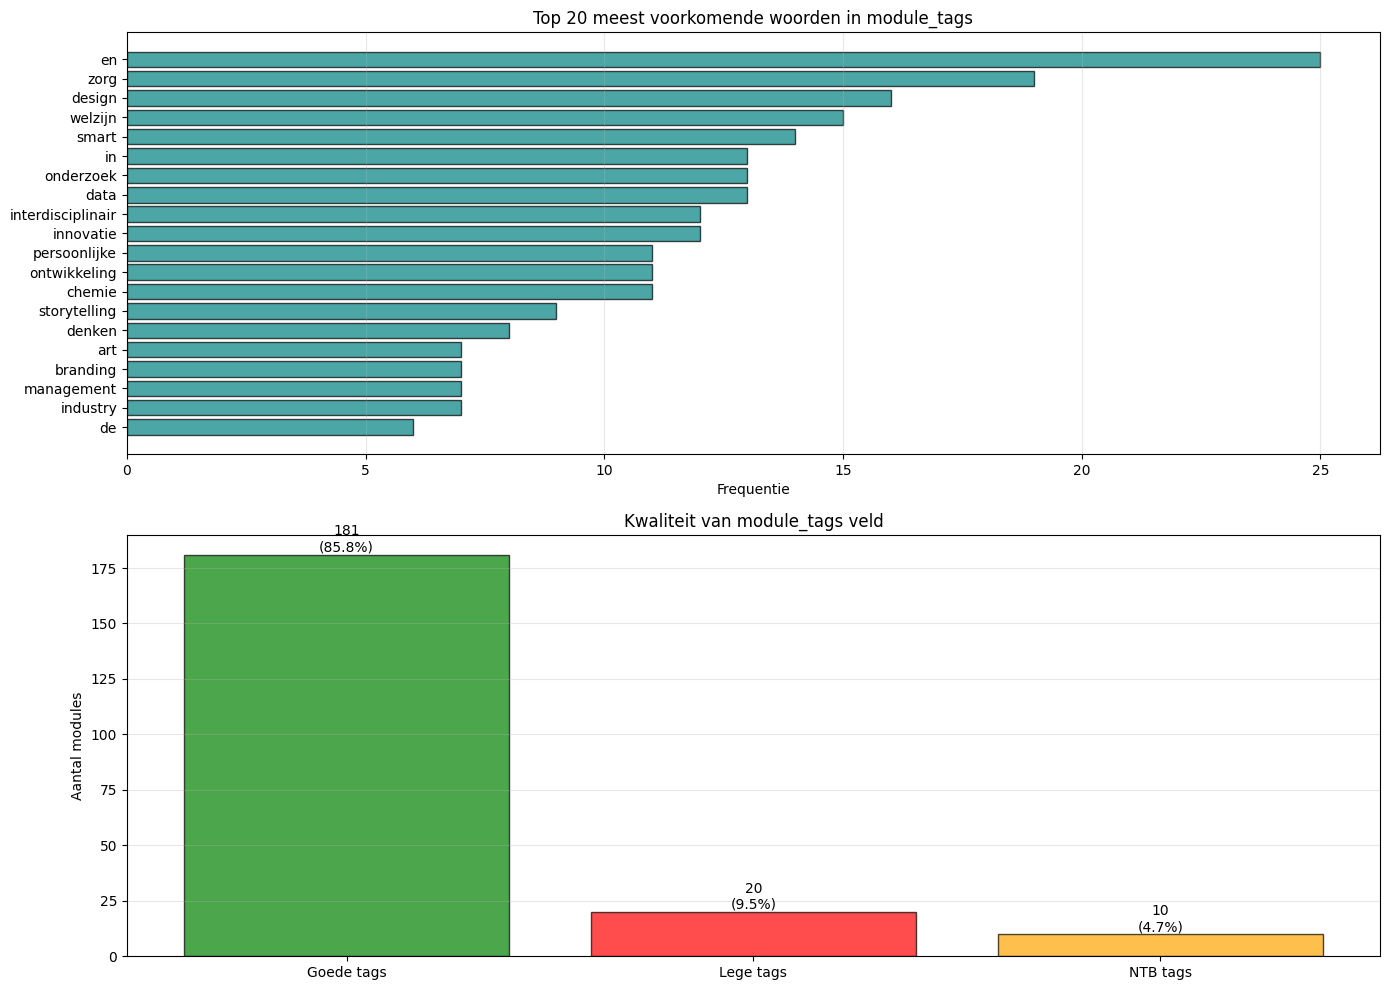


Conclusie: 30 modules hebben geen bruikbare tags (14.2%)


In [ ]:
all_tags = []
empty_tags = 0
ntb_tags = 0

for tag_string in df['module_tags'].astype(str):
    cleaned = tag_string.replace('[', '').replace(']', '').replace("'", "").replace('"', '').strip()
    
    if cleaned == '' or cleaned.lower() in ['nan', 'none']:
        empty_tags += 1
        continue
    if 'ntb' in cleaned.lower():
        ntb_tags += 1
        continue
    
    tags = [t.strip().lower() for t in cleaned.split(',') if t.strip()]
    all_tags.extend(tags)
from collections import Counter
tag_counter = Counter(all_tags)
top_20 = tag_counter.most_common(20)

# Visualisatie
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top 20 woorden
words, counts = zip(*top_20) if top_20 else ([], [])
axes[0].barh(range(len(words)), counts, color='teal', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequentie')
axes[0].set_title('Top 20 meest voorkomende woorden in module_tags')
axes[0].grid(axis='x', alpha=0.3)

# Tag kwaliteit overzicht
tag_quality = {
    'Goede tags': len(df) - empty_tags - ntb_tags,
    'Lege tags': empty_tags,
    'NTB tags': ntb_tags
}
axes[1].bar(tag_quality.keys(), tag_quality.values(), color=['green', 'red', 'orange'], edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Aantal modules')
axes[1].set_title('Kwaliteit van module_tags veld')
axes[1].grid(axis='y', alpha=0.3)

for i, (key, val) in enumerate(tag_quality.items()):
    pct = (val / len(df)) * 100
    axes[1].text(i, val, f'{val}\n({pct:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Bereken data quality score per module

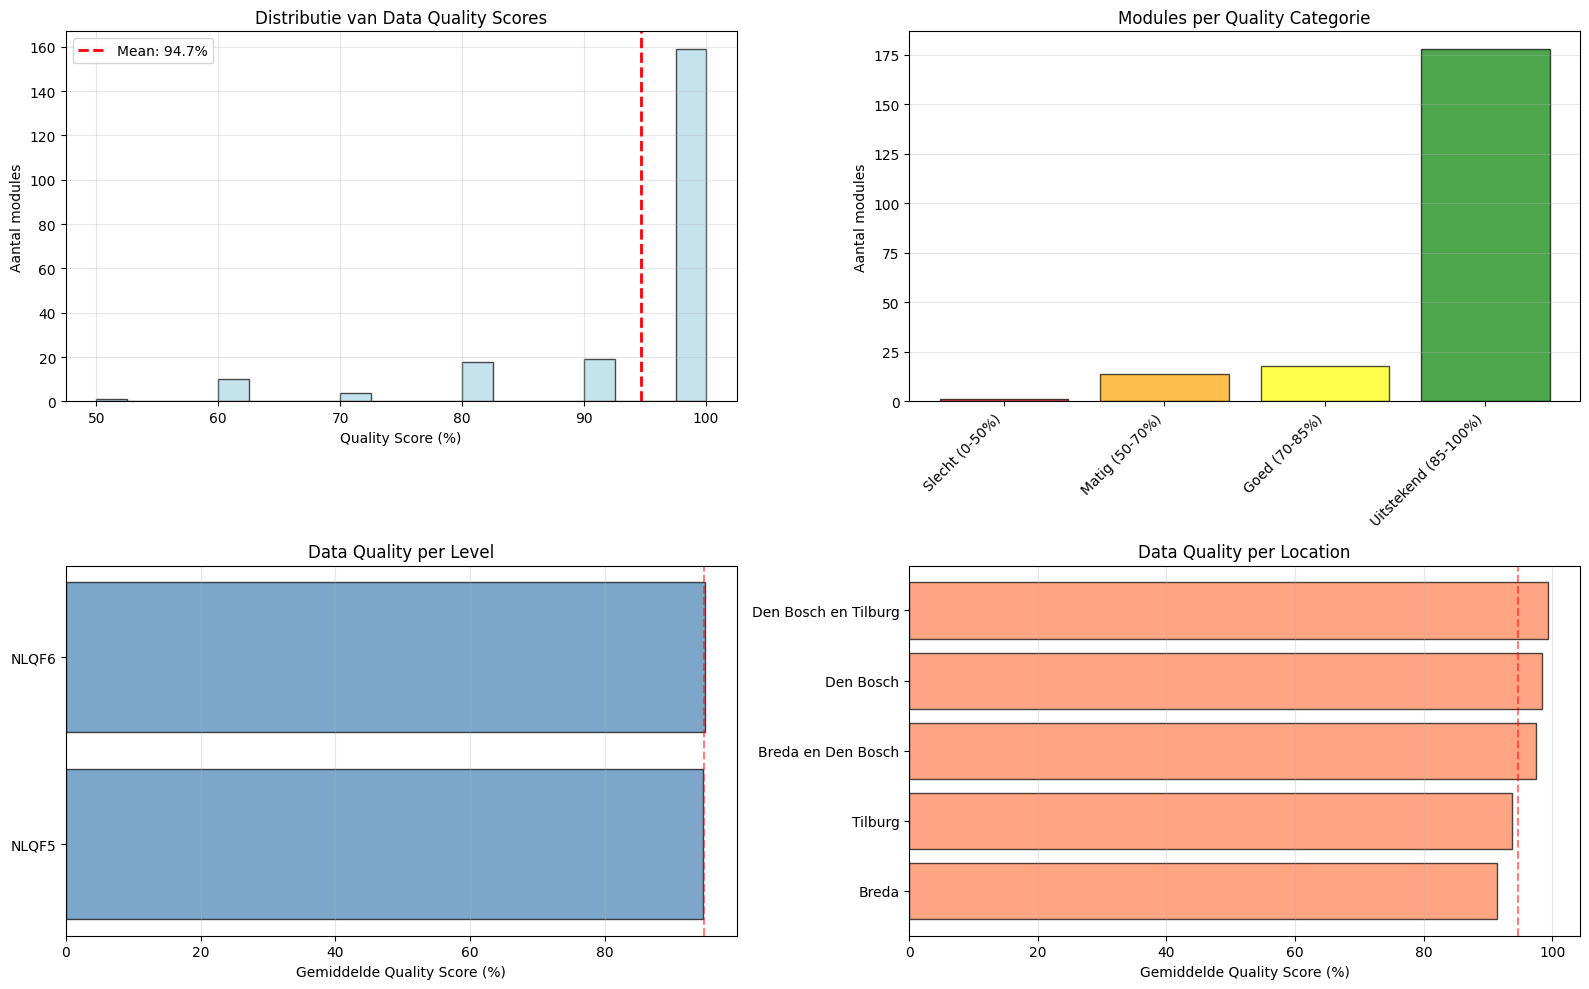


Conclusie: Op basis van deze analyse kunnen we gericht gaan schoonmaken


In [ ]:
text_cols = ['name', 'description', 'content', 'shortdescription', 'module_tags', 'location', 'level']
df['quality_issues'] = 0

for col in text_cols:
    df['quality_issues'] += df[col].isnull().astype(int)
    df['quality_issues'] += (df[col].astype(str).str.strip() == '').astype(int)
    df['quality_issues'] += df[col].astype(str).str.lower().str.contains('ntb|nog te bepalen', na=False).astype(int)

for col in ['description', 'content', 'shortdescription']:
    df['quality_issues'] += (df[col].astype(str).str.len() < 30).astype(int)

max_issues = len(text_cols) + 3
df['quality_score'] = ((max_issues - df['quality_issues']) / max_issues * 100).round(1)
df['quality_category'] = pd.cut(df['quality_score'], 
                                 bins=[0, 50, 70, 85, 100], 
                                 labels=['Slecht (0-50%)', 'Matig (50-70%)', 'Goed (70-85%)', 'Uitstekend (85-100%)'])

# Visualisaties
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram van quality scores
axes[0, 0].hist(df['quality_score'], bins=20, edgecolor='black', color='lightblue', alpha=0.7)
axes[0, 0].axvline(df['quality_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['quality_score'].mean():.1f}%")
axes[0, 0].set_xlabel('Quality Score (%)')
axes[0, 0].set_ylabel('Aantal modules')
axes[0, 0].set_title('Distributie van Data Quality Scores')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Quality categories
cat_counts = df['quality_category'].value_counts().sort_index()
colors = ['red', 'orange', 'yellow', 'green']
axes[0, 1].bar(range(len(cat_counts)), cat_counts.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].set_xticks(range(len(cat_counts)))
axes[0, 1].set_xticklabels(cat_counts.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Aantal modules')
axes[0, 1].set_title('Modules per Quality Categorie')
axes[0, 1].grid(axis='y', alpha=0.3)

# Quality score per level
quality_per_level = df.groupby('level')['quality_score'].mean().sort_values()
axes[1, 0].barh(range(len(quality_per_level)), quality_per_level.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_yticks(range(len(quality_per_level)))
axes[1, 0].set_yticklabels(quality_per_level.index)
axes[1, 0].set_xlabel('Gemiddelde Quality Score (%)')
axes[1, 0].set_title('Data Quality per Level')
axes[1, 0].axvline(df['quality_score'].mean(), color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(axis='x', alpha=0.3)

# Quality score per location
quality_per_loc = df.groupby('location')['quality_score'].mean().sort_values()
axes[1, 1].barh(range(len(quality_per_loc)), quality_per_loc.values, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(quality_per_loc)))
axes[1, 1].set_yticklabels(quality_per_loc.index)
axes[1, 1].set_xlabel('Gemiddelde Quality Score (%)')
axes[1, 1].set_title('Data Quality per Location')
axes[1, 1].axvline(df['quality_score'].mean(), color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Cleanup temp kolommen
df.drop(['quality_issues', 'quality_score', 'quality_category'], axis=1, inplace=True)

## Analyseer woorden in descriptions voor tag generatie

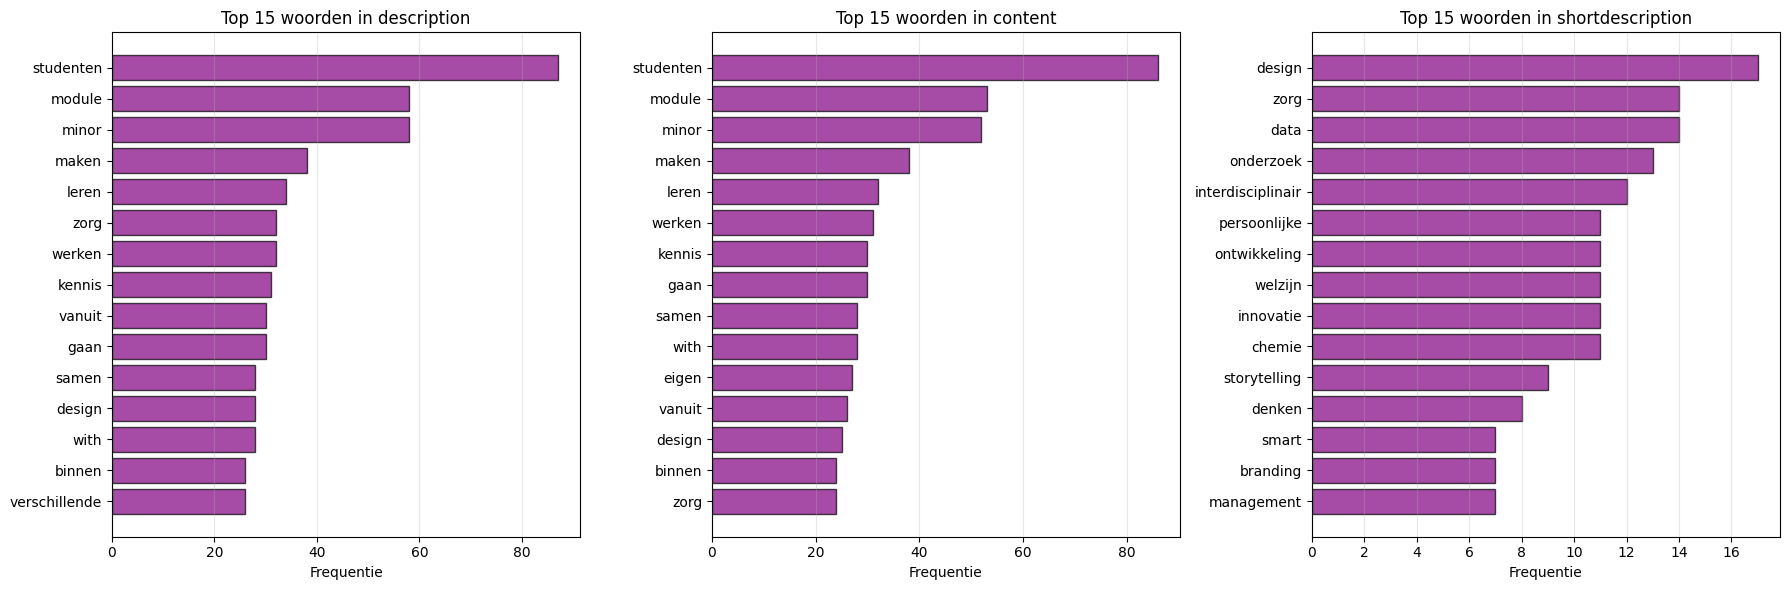


394 woorden komen voor in alle 3 de velden
Deze woorden kunnen handig zijn voor het genereren van tags


In [ ]:
dutch_stops = set(stopwords.words('dutch'))
word_freq = {}

for field in ['description', 'content', 'shortdescription']:
    all_words = []
    
    for text in df[field].astype(str):
        if 'ntb' in text.lower() or 'nog te bepalen' in text.lower() or len(text) < 30:
            continue
        
        words = re.findall(r'\b\w+\b', text.lower())
        filtered = [w for w in words if w not in dutch_stops and len(w) >= 4 and not w.isdigit()]
        all_words.extend(filtered)
    
    from collections import Counter
    counter = Counter(all_words)
    word_freq[field] = counter
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, field in enumerate(['description', 'content', 'shortdescription']):
    top_15 = word_freq[field].most_common(15)
    if top_15:
        words, counts = zip(*top_15)
        axes[idx].barh(range(len(words)), counts, color='purple', edgecolor='black', alpha=0.7)
        axes[idx].set_yticks(range(len(words)))
        axes[idx].set_yticklabels(words)
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('Frequentie')
        axes[idx].set_title(f'Top 15 woorden in {field}')
        axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Vind gemeenschappelijke woorden
common_words = set(word_freq['description'].keys()) & set(word_freq['content'].keys()) & set(word_freq['shortdescription'].keys())

# Data Cleaning - Op basis van bovenstaande analyses

## Standaardiseer alle lege en ntb waarden

In [16]:
# Standaardiseer alle varianten van lege waarden naar consistent formaat

print("Standaardisatie van lege waarden")
print("=" * 60)

vooraf_ntb = {}
for col in df.columns:
    if df[col].dtype == 'object':
        vooraf_ntb[col] = (df[col] == 'Nog te bepalen').sum()

for col in df.columns:
    if df[col].dtype == 'object':
        for i in df.index:
            cell_value = str(df.loc[i, col]).strip()
            
            if col == 'module_tags':
                if cell_value in ['[]', "['ntb']", '["ntb"]', 'ntb']:
                    df.loc[i, col] = 'Nog te bepalen'
            else:
                if pd.isna(df.loc[i, col]) or cell_value == '' or cell_value.lower() in ['ntb', 'nog niet bekend', 'nog te formuleren']:
                    df.loc[i, col] = 'Nog te bepalen'

df.drop(['Rood', 'Groen', 'Blauw', 'Geel'], axis=1, inplace=True, errors='ignore')

print("\nResultaat na standaardisatie:")
for col in df.columns:
    if df[col].dtype == 'object':
        na_ntb = (df[col] == 'Nog te bepalen').sum()
        verschil = na_ntb - vooraf_ntb.get(col, 0)
        if verschil > 0:
            print(f"  {col}: {vooraf_ntb.get(col, 0)} -> {na_ntb} (+{verschil})")

Standaardisatie van lege waarden

Resultaat na standaardisatie:
  shortdescription: 0 -> 30 (+30)
  description: 0 -> 4 (+4)
  content: 0 -> 4 (+4)
  learningoutcomes: 0 -> 55 (+55)
  module_tags: 0 -> 30 (+30)


## Valideer tekstlengtes en markeer te korte velden

In [17]:
# Teksten korter dan 30 karakters zijn te kort voor goede analyse

print("Kwaliteitscontrole tekstlengte")
print("=" * 60)

print("Vooraf:")
print(f"  description 'Nog te bepalen': {(df['description'] == 'Nog te bepalen').sum()}")
print(f"  content 'Nog te bepalen': {(df['content'] == 'Nog te bepalen').sum()}")

min_length = 30
for i in df.index:
    for col in ['description', 'content']:
        if df.loc[i, col] != 'Nog te bepalen':
            text_len = len(str(df.loc[i, col]).strip())
            if text_len <= min_length:
                df.loc[i, col] = 'Nog te bepalen'

print(f"\nNa controle (min {min_length} karakters):")
print(f"  description 'Nog te bepalen': {(df['description'] == 'Nog te bepalen').sum()}")
print(f"  content 'Nog te bepalen': {(df['content'] == 'Nog te bepalen').sum()}")

Kwaliteitscontrole tekstlengte
Vooraf:
  description 'Nog te bepalen': 4
  content 'Nog te bepalen': 4

Na controle (min 30 karakters):
  description 'Nog te bepalen': 7
  content 'Nog te bepalen': 12


## Vul shortdescription aan met beschikbare data

In [18]:
# Vul ontbrekende shortdescription aan met data uit description en content velden

print("Aanvullen shortdescription met beschikbare data")
print("=" * 60)

ntb_voor = (df['shortdescription'] == 'Nog te bepalen').sum()
print(f"Vooraf shortdescription 'Nog te bepalen': {ntb_voor}")

for i in df.index:
    if df.loc[i, 'shortdescription'] == 'Nog te bepalen':
        desc = str(df.loc[i, 'description']) if df.loc[i, 'description'] != 'Nog te bepalen' else ''
        cont = str(df.loc[i, 'content']) if df.loc[i, 'content'] != 'Nog te bepalen' else ''
        combined = (desc + ' ' + cont).strip()
        df.loc[i, 'shortdescription'] = combined if combined else 'Nog te bepalen'

ntb_na = (df['shortdescription'] == 'Nog te bepalen').sum()
gevuld = ntb_voor - ntb_na
print(f"Na aanvullen shortdescription 'Nog te bepalen': {ntb_na}")
print(f"Aantal gevulde velden: {gevuld}")

Aanvullen shortdescription met beschikbare data
Vooraf shortdescription 'Nog te bepalen': 30
Na aanvullen shortdescription 'Nog te bepalen': 4
Aantal gevulde velden: 26


## Genereer automatisch tags uit beschrijvingen

In [19]:
# Genereer automatisch tags uit belangrijke woorden in beschrijvingen
# Gebruik stopwoordenfiltering en woordlengte voor betere tag kwaliteit

print("Genereren van tags uit belangrijke woorden")
print("=" * 60)

dutch_stops = set(stopwords.words('dutch'))

ntb_voor = (df['module_tags'] == 'Nog te bepalen').sum()
print(f"Vooraf module_tags 'Nog te bepalen': {ntb_voor}")

for i in df.index:
    if df.loc[i, 'module_tags'] == 'Nog te bepalen':
        
        text = str(df.loc[i, 'shortdescription'])
        woorden = re.findall(r'\b\w+\b', text.lower())
        # Filter stopwoorden en gebruik min lengte van 4 (gebaseerd op Analyse 5)
        tags = [w for w in woorden if w not in dutch_stops and len(w) >= 4 and w not in ['nog', 'bepalen']]
        
        if not tags:
            name_text = str(df.loc[i, 'name'])
            name_woorden = re.findall(r'\b\w+\b', name_text.lower())
            tags = [w for w in name_woorden if w not in dutch_stops and len(w) >= 4 and w not in ['nog', 'bepalen']]
        
        df.loc[i, 'module_tags'] = str(tags[:5]) if tags else "['algemeen']"  # Max 5 tags

ntb_na = (df['module_tags'] == 'Nog te bepalen').sum()
gegenereerd = ntb_voor - ntb_na
print(f"Na genereren module_tags 'Nog te bepalen': {ntb_na}")
print(f"Aantal gegenereerde tag velden: {gegenereerd}")
print(f"Aantal gegenereerde tag velden: {gegenereerd}")

Genereren van tags uit belangrijke woorden
Vooraf module_tags 'Nog te bepalen': 30
Na genereren module_tags 'Nog te bepalen': 0
Aantal gegenereerde tag velden: 30
Aantal gegenereerde tag velden: 30


## Export dataset en toon overzicht

In [20]:
# Exporteer opgeschoonde dataset naar CSV en rapporteer kwaliteit

print("Overzicht na data cleaning")
print("=" * 60)

output_file = 'Opgeschoonde_VKM_dataset.csv'
df.to_csv(output_file, index=False, encoding='utf-8')
print(f"Dataset geexporteerd naar: {output_file}")

print("\nResterende 'Nog te bepalen' waarden:")
totaal_ntb = 0
for col in df.columns:
    if df[col].dtype == 'object':
        ntb_count = (df[col] == 'Nog te bepalen').sum()
        if ntb_count > 0:
            perc = round((ntb_count / len(df)) * 100, 1)
            print(f"  {col}: {ntb_count} ({perc}%)")
            totaal_ntb += ntb_count

print(f"\nTotaal resterende problemen: {totaal_ntb}")
print(f"Percentage opgeschoond: {((1 - totaal_ntb / (len(df) * len(df.columns))) * 100):.1f}%")

Overzicht na data cleaning
Dataset geexporteerd naar: Opgeschoonde_VKM_dataset.csv

Resterende 'Nog te bepalen' waarden:
  shortdescription: 4 (1.9%)
  description: 7 (3.3%)
  content: 12 (5.7%)
  learningoutcomes: 55 (26.1%)

Totaal resterende problemen: 78
Percentage opgeschoond: 97.7%
